# Carry Tables

In [183]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
import random
import functions
import math
import pickle
from tqdm.notebook import tqdm_notebook

In [2]:
%load_ext autoreload
%autoreload 2

## Display Carry Tables

In [3]:
d=4 #modulus

basic_table=1*(np.add.outer(np.arange(d),np.arange(d))>=d)
alt_table=np.array([[0,0,0,0],
                    [0,3,3,3],
                    [0,3,3,0],
                    [0,3,0,0]])

### Basic Table, depth $\in [1:3]$

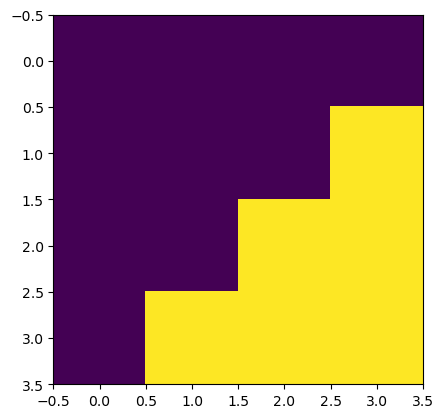

In [4]:
plt.imshow(functions.construct_product_table(basic_table,1))

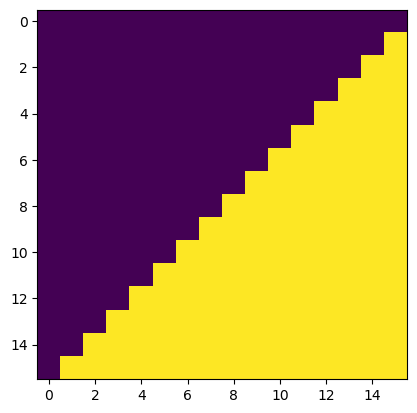

In [5]:
plt.imshow(functions.construct_product_table(basic_table,2))

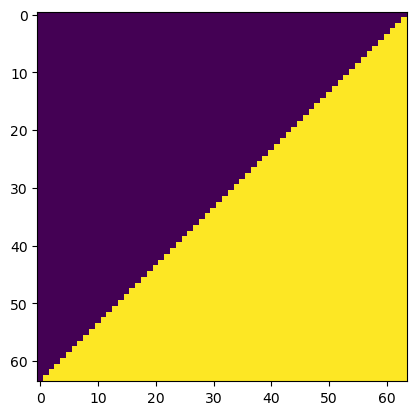

In [6]:
plt.imshow(functions.construct_product_table(basic_table,3))

### Alternative Table, depth $\in [1:4]$

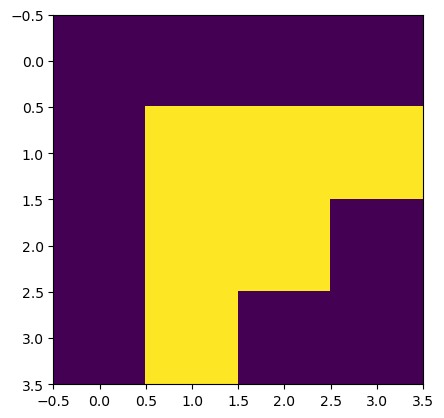

In [7]:
plt.imshow(functions.construct_product_table(alt_table,1))

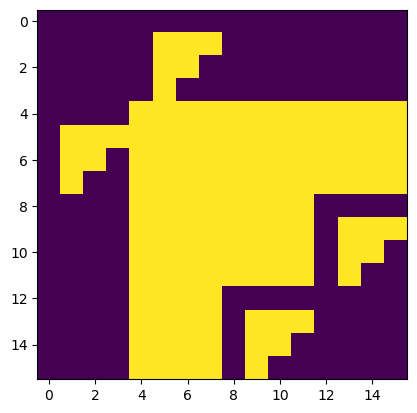

In [8]:
plt.imshow(functions.construct_product_table(alt_table,2))

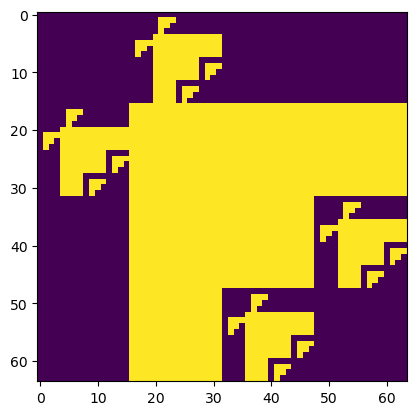

In [9]:
plt.imshow(functions.construct_product_table(alt_table,3))

## Compare Carry Tables

### Find alternative cocycles

In [12]:
tables3 = functions.construct_tables(3)

  0%|          | 0/9 [00:00<?, ?it/s]

In [13]:
tables4 = functions.construct_tables(4)

  0%|          | 0/64 [00:00<?, ?it/s]

In [14]:
tables5 = functions.construct_tables(5, sample=True, frac=0.5)

  0%|          | 0/625 [00:00<?, ?it/s]

In [21]:
tables6 = functions.construct_tables(6, sample=True, frac=0.5)

  0%|          | 0/7776 [00:00<?, ?it/s]

In [16]:
tables7 = functions.construct_tables(7, sample=True, frac=0.1)

  0%|          | 0/117649 [00:00<?, ?it/s]

In [22]:
tables8 = functions.construct_tables(8, sample=True, n=5)

  0%|          | 0/2097152 [00:00<?, ?it/s]

In [155]:
all_tables = {
    3: tables3,
    4: tables4,
    5: tables5,
    6: tables6,
    7: tables7,
    8: tables8,
    # 9: tables9,
    # 10: tables10
}

In [156]:
with open('carry_tables/all_tables.pickle', 'wb') as f:
    pickle.dump(all_tables, f)

### Plot their carry tables

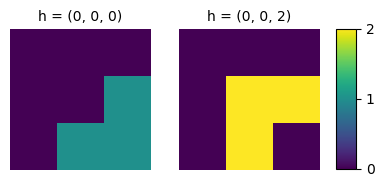

In [144]:
functions.show_tables(tables3, 3, depth=1)

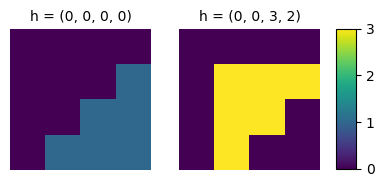

In [145]:
functions.show_tables(tables4, 4, depth=1)

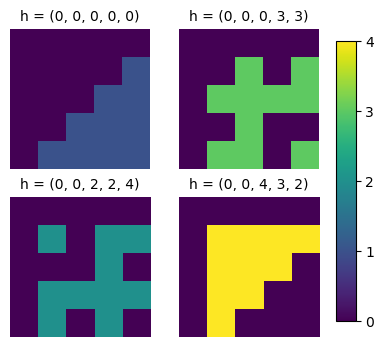

In [146]:
functions.show_tables(tables5, 5, depth=1)

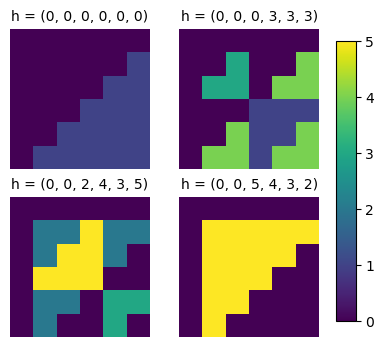

In [147]:
functions.show_tables(tables6, 6, depth=1)

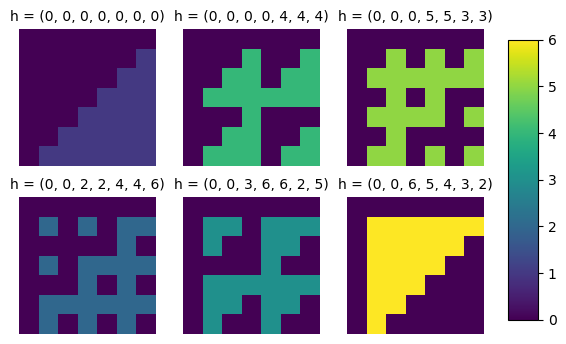

In [148]:
functions.show_tables(tables7, 7, depth=1)

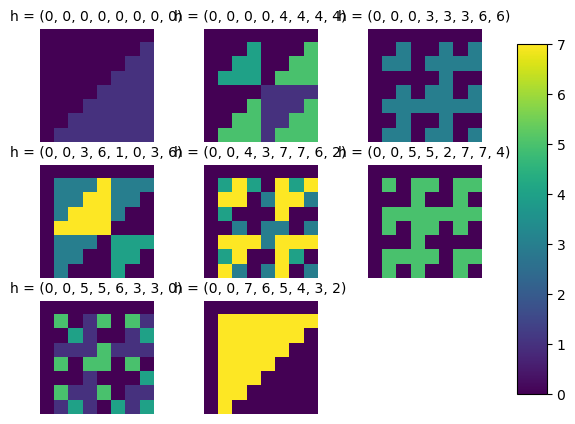

In [169]:
show_tables(tables8, 8, depth=1)

### Check how the recursive tables compare in terms of isomorphisms of groups -- **IN PROGRESS**

In [ ]:
h = '(0, 0, 0, 0, 0, 0)'
zero = RecursiveGrpElt((0, 0), tables6[h])
one = RecursiveGrpElt((0, 1), tables6[h])
cycle = [e.vals]
for t in range(g.d**len(g.vals) - 1):
    e += g
    cycle.append(e.vals)

### Count number of zeros, number of unique digits in each table

In [184]:
# initialize dictionaries
num_zeros_vs_depth = {b: {h: [] for h in all_tables[b].keys()} for b in range(3, 9)}
num_digits_vs_depth = {b: {h: [] for h in all_tables[b].keys()} for b in range(3, 9)}

# iterate through bases and h's
for b in tqdm_notebook(range(3, 9)):
    for h in all_tables[b].keys():
        for depth in range(1, 5):
            table = functions.construct_product_table(all_tables[b][h], depth=depth)
            num_zeros = table.size - np.count_nonzero(table)
            num_zeros_vs_depth[b][h].append(num_zeros)
            num_digits = len(np.unique(table))
            num_digits_vs_depth[b][h].append(num_digits)

  0%|          | 0/6 [00:00<?, ?it/s]

In [187]:
with open('carry_tables/num_zeros_vs_depth.pickle', 'wb') as f:
    pickle.dump(num_zeros_vs_depth, f)

In [188]:
with open('carry_tables/num_digits_vs_depth.pickle', 'wb') as f:
    pickle.dump(num_digits_vs_depth, f)

### Plot number of zeros and number of unique digits

/var/folders/qd/lngl0tnd4557ml_18l05dm8r0000gn/T/ipykernel_6101/230777352.py:14: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


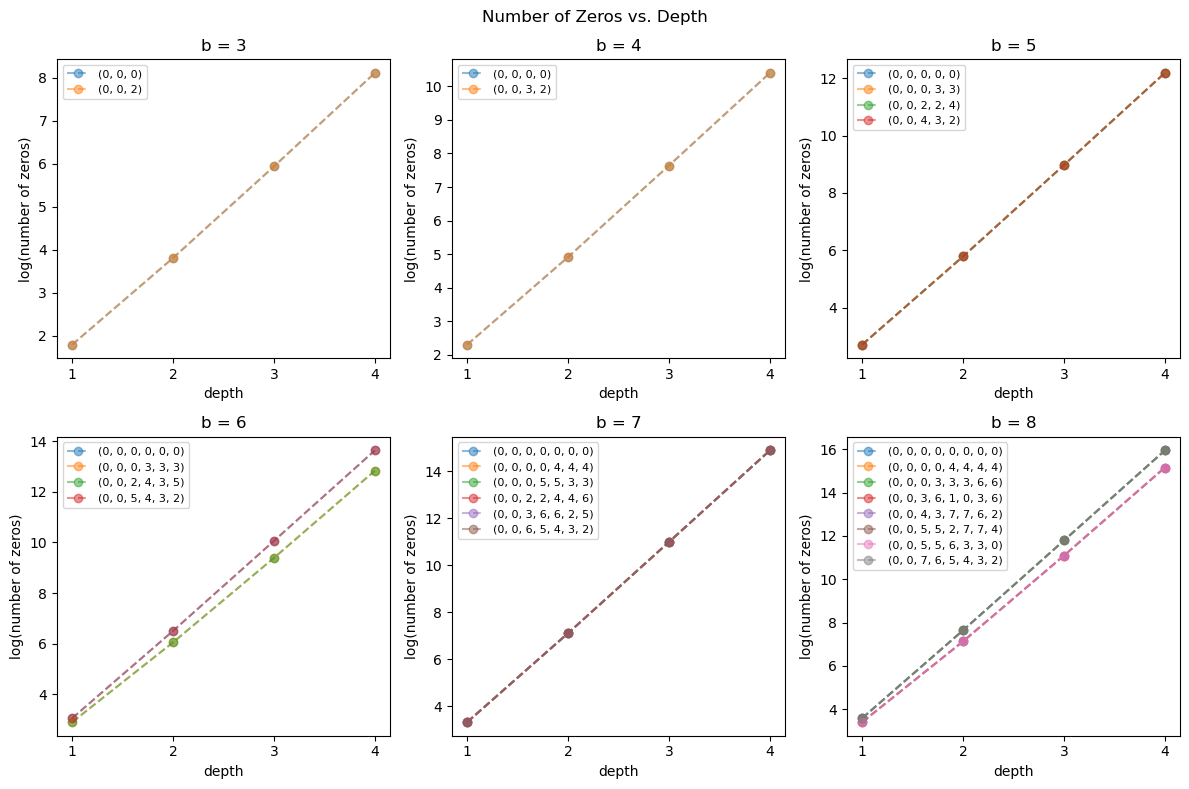

In [215]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()
for i in range(len(axes)):
    ax = axes[i]
    tables = all_tables[i+3]
    for h in tables.keys():
        ax.plot(np.log(num_zeros_vs_depth[i+3][h]), alpha=0.5, marker='o', linestyle='--', label=h)
        ax.set_xticks([0, 1, 2, 3], [1, 2, 3, 4])
        ax.set_xlabel('depth')
        ax.set_ylabel('log(number of zeros)')
        ax.set_title('b = '+str(i+3))
        ax.legend(fontsize=8)
    fig.suptitle('Number of Zeros vs. Depth')
    plt.tight_layout()

/var/folders/qd/lngl0tnd4557ml_18l05dm8r0000gn/T/ipykernel_6101/2822114267.py:15: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


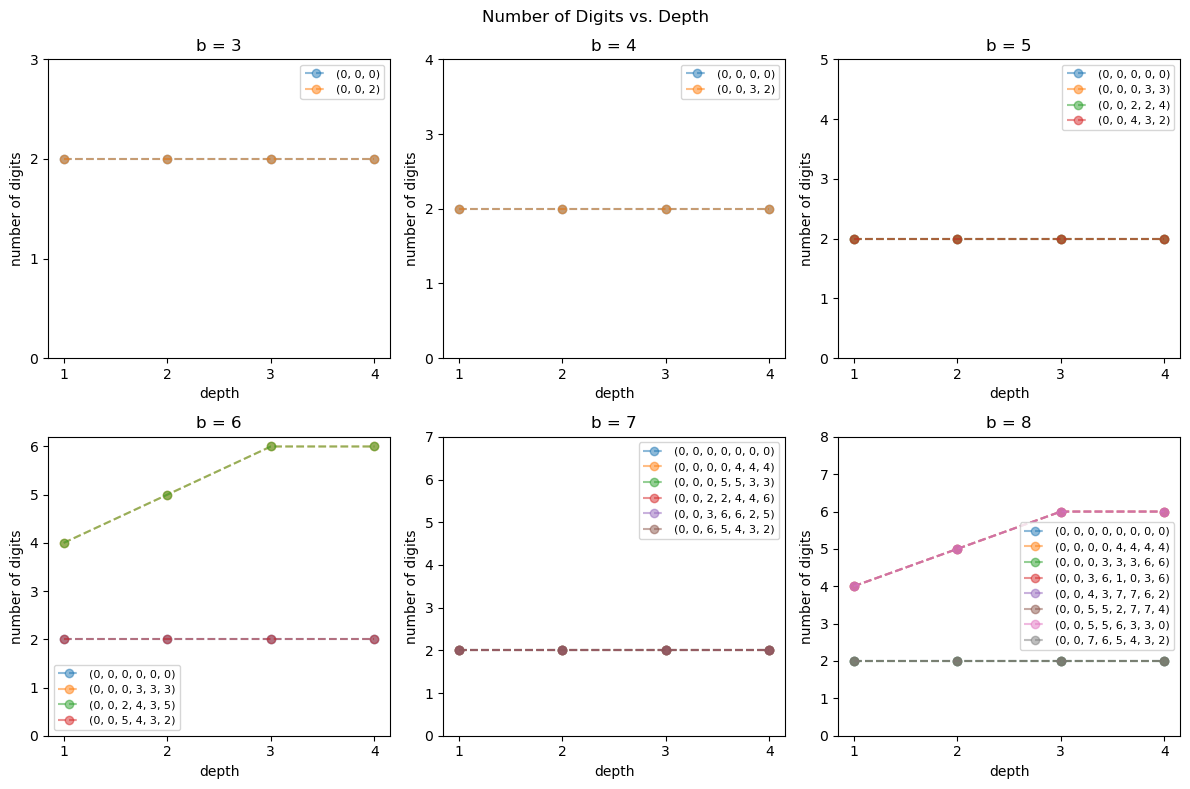

In [219]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()
for i in range(len(axes)):
    ax = axes[i]
    tables = all_tables[i+3]
    for h in tables.keys():
        ax.plot(num_digits_vs_depth[i+3][h], alpha=0.5, marker='o', linestyle='--', label=h)
        ax.set_xticks([0, 1, 2, 3], [1, 2, 3, 4])
        ax.set_yticks(range(i+4))
        ax.set_xlabel('depth')
        ax.set_ylabel('number of digits')
        ax.set_title('b = '+str(i+3))
        ax.legend(fontsize=8)
    fig.suptitle('Number of Digits vs. Depth')
    plt.tight_layout()

### Check that recursive tables are still cocycles

In [192]:
for b in tqdm_notebook(range(3, 9)):
    for h in all_tables[b].keys():
        table = all_tables[b][h]
        for depth in range(1, 3):
            if (functions.assert_cocycle(table, depth=depth) == False):
                print(b, h, depth)

  0%|          | 0/6 [00:00<?, ?it/s]